In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import itertools

import random

import pandas as pd

from sklearn.metrics import roc_curve, auc

ignore_colms = ['sender', 'receiver', 'transaction']
label_colm = 'transaction'

In [2]:
def load_features_file(convert_to_bin_trans, svd_k, nmf_n, unq_senders, unq_receivers):
    filename_postfix = '_bin{}_svd{}_nmf{}_snd{}_rcv{}.csv'.format(str(convert_to_bin_trans), str(svd_k), str(nmf_n), str(unq_senders), str(unq_receivers))
    ftrain = pd.read_csv('features/train' + filename_postfix, index_col=0)
    ftest = pd.read_csv('features/test' + filename_postfix, index_col=0)
    return ftrain, ftest


def get_train_test_matricies(traindf, testdf):
    train_X = traindf.drop(ignore_colms, axis=1).as_matrix()
    train_Y = traindf[label_colm].values
    
    test_X = testdf.drop(ignore_colms, axis=1).as_matrix()
    test_true_Y = testdf[label_colm].values
    return train_X, train_Y, test_X, test_true_Y

In [3]:
# Load DFs
bin_trans = True
svd_k = 50
nmf_n = 12
unq_senders = 250
unq_receivers = 100

traindf, testdf = load_features_file(bin_trans, svd_k, nmf_n, unq_senders, unq_receivers)
train_X, train_Y, test_X, test_true_Y = get_train_test_matricies(traindf, testdf)

In [4]:
from itertools import cycle

from time import time
from operator import itemgetter

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV, Perceptron

from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import  cross_val_score

from scipy.stats import randint as sp_randint

from sklearn.cluster import KMeans
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from scipy import interp
from sklearn import svm
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score, classification_report, confusion_matrix, average_precision_score
from sklearn.naive_bayes import MultinomialNB

import time

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
# Function to run and get stats for any classifier
def simple_any(clf, train_features, train_labels, test_features, test_true_labels):
    start_time = time.time()
    stats = dict()
    clf = clf.fit(train_features, train_labels)

    train_predicted_labels = clf.predict(train_features)
    test_predicted_labels = clf.predict(test_features)

    y_score = clf.predict_proba(test_features)
    
    stats['false_pv_arr'], stats['true_pv_arr'], thresholds = roc_curve(test_true_labels, y_score[:, 1])
    stats['auc'] = auc(stats['false_pv_arr'], stats['true_pv_arr'])
    stats['precision_recall_f1'] = classification_report(test_true_labels, test_predicted_labels)
    stats['confusion_matrix'] = confusion_matrix(test_true_labels, test_predicted_labels)
    stats['test_accuracy'] = accuracy_score(test_true_labels, test_predicted_labels)
    return stats


def get_guess(cluster, kmeans, train_Y):
    inds = np.where(kmeans.labels_ == cluster)[0]
    return mode(train_Y[inds])[0][0]


def perform_k_means(train_X, train_Y, test_X, test_true_Y, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(train_X)
    cluster_preds = kmeans.predict(test_X)

    guess_preds = np.array([get_guess(cl, kmeans, train_Y) for cl in cluster_preds])

    stats = dict()
    stats['false_pv_arr'], stats['true_pv_arr'], thresholds = roc_curve(test_true_Y, guess_preds)
    stats['auc'] = auc(stats['false_pv_arr'], stats['true_pv_arr'])
    stats['precision_recall_f1'] = classification_report(test_true_Y, guess_preds)
    stats['confusion_matrix'] = confusion_matrix(test_true_Y, guess_preds)
    stats['test_accuracy'] = accuracy_score(test_true_Y, guess_preds)
    return stats


def plt_all_clfs_roc(stats):
    colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'magenta']

    plt.figure()
    lw = 2
    for i, stat_name in enumerate(stats):
        stat = stats[stat_name]
        plt.plot(stat['false_pv_arr'], stat['true_pv_arr'], 
            color=colors[i], lw=lw, label='{} (AUC = {})'.format(stat_name, round(stat['auc'],2)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


def get_clfs():
    lr_clf = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-4, 4))), penalty='l2', scoring='roc_auc')
    dt_clf = DecisionTreeClassifier()
    ab_clf = AdaBoostClassifier(learning_rate=0.5, n_estimators=50)
    svml_clf = svm.SVC(kernel='linear', C=1000, probability=True)
    svmr_clf = svm.SVC(kernel='rbf', C=10.0, gamma=10, probability=True)
    rf_clf = RandomForestClassifier(n_estimators=1000)
    knn_clf = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=100)
    
    return [(lr_clf, "LR"), (dt_clf, "DT"), (ab_clf, "AB"), (svml_clf, "SVML"), 
        (svmr_clf, "SVMR"), (rf_clf, "RF"), (knn_clf, "KNN")]


def classify(train_X, train_Y, test_X, test_true_Y):
    results = {}
    for clf, name in get_clfs():
        results[name] = simple_any(clf, train_X, train_Y, test_X, test_true_Y)
    
    results["KMeans"] = perform_k_means(train_X, train_Y, test_X, test_true_Y, 1000)
    return results

In [6]:
def get_clf_cvd(clf, tuned_parameters, X, y):
    gcv_clf = GridSearchCV(clf, tuned_parameters, cv=5, scoring='roc_auc', verbose=5, n_jobs=-1)
    gcv_clf.fit(X, y)
    clf.set_params(**gcv_clf.best_params_)
    return clf


def get_cvd_clfs(train_X, train_Y):
    lr_clf = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-4, 4))), penalty='l2', scoring='roc_auc')
    dt_clf = DecisionTreeClassifier()

    tuned_parameters = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [.01, .1, 0.5, 1] }
    ab_clf = get_clf_cvd(AdaBoostClassifier(learning_rate=0.5, n_estimators=50), tuned_parameters, train_X, train_Y)

    tuned_parameters = {'C': list(np.power(10.0, np.arange(-1, 4)))}
    svml_clf = get_clf_cvd(svm.SVC(kernel='linear', C=10, probability=True), tuned_parameters, train_X, train_Y)


    tuned_parameters = {'C': list(np.power(10.0, np.arange(-2, 2))), 'gamma': list(np.power(10.0, np.arange(-2, 2)))}
    svmr_clf = get_clf_cvd(svm.SVC(kernel='rbf', gamma=0.5, probability=True), tuned_parameters, train_X, train_Y)

    tuned_parameters = {'n_estimators': [300, 500, 1000] }
    rf_clf = get_clf_cvd(RandomForestClassifier(), tuned_parameters, train_X, train_Y)


    tuned_parameters = {'n_neighbors': [5, 10, 50, 100] }
    knn_clf = get_clf_cvd(KNeighborsClassifier(algorithm='kd_tree'), tuned_parameters, train_X, train_Y)

    return [(lr_clf, "LR"), (dt_clf, "DT"), (ab_clf, "AB"), (svml_clf, "SVML"), 
        (svmr_clf, "SVMR"), (rf_clf, "RF"), (knn_clf, "KNN")]

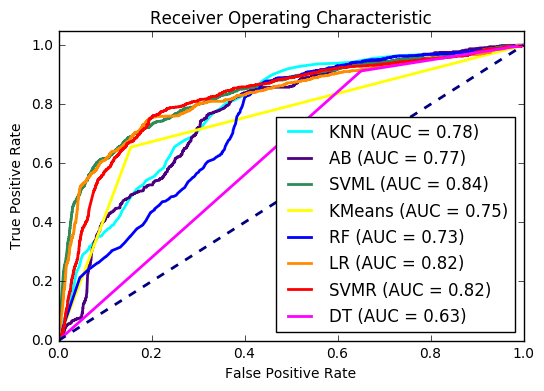

In [7]:
results = []

class_result = classify(train_X, train_Y, test_X, test_true_Y)
plt_all_clfs_roc(class_result)

results.append(class_result)